# Introduction: descriptive analysis of MLA conference abstracts

 
## What does this code do?

I'm analyzing data from the Medical Library Association annual meeting abstracts from 2001-2019. MLA abstracts are available to download in PDF format from [their website](https://www.mlanet.org/page/past-and-future-meetings). The CSV data used in this notebook is available for download or to browse online [here](http://bit.ly/mlameetings).

# Setup

## Import libraries

In [16]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

In [17]:
# start a timer if you want to time how long this takes. Change this block's type to Code to run.
start_time = time.time()

## Import data

In [37]:
# change these paths if necessary
mla = pd.read_csv("mla.csv", encoding="latin1")
jmla = pd.read_csv("JMLA.csv")

# Basic information

In [19]:
### print basic information ###################################################
print("There were " + str(len(mla.index)) + " presentations at MLA annual meetings between 2001-2019.")

number_posters = mla.query("Type == 'poster'").Type.count()
number_papers = mla.query("Type == 'paper'").Type.count()

print("There were " +str(number_posters) + " total poster presentations.")
print("There were " +str(number_papers) + " total paper presentations.")
print("There were " + str(sum(jmla["Number"])) + " items published in JMLA 2001-July 1 2019.")

There were 5781 presentations at MLA annual meetings between 2001-2019.
There were 3388 total poster presentations.
There were 2393 total paper presentations.
There were 1205 items published in JMLA 2001-July 1 2019.


## Plot number of articles, posters, and presentations

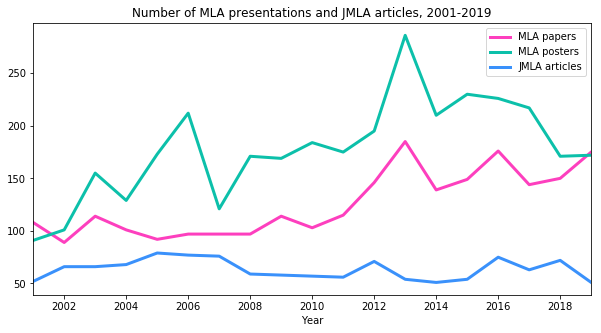

In [20]:
#group the sessions by type and year
number_papers_year = mla.groupby(['Year','Type'])["Title"].count()
#pivot
number_papers_year = number_papers_year.unstack(level=-1)
#change index of jmla to be the year so it matches the number_papers_year format
jmla = jmla.set_index("Year")
#concatenate jmla and mla
number_all_year = pd.concat([number_papers_year, jmla], axis=1)
number_all_year = number_all_year.rename({"Number": "JMLA articles", "paper":"MLA papers", "poster":"MLA posters"}, axis=1)
#print(number_all_year)
### plot basic information
styles=["#fd3fbe", "#0cc0aa", "#3a91fb"]
lines = number_all_year.plot.line(figsize=(10,5), style=styles, title="Number of MLA presentations and JMLA articles, 2001-2019", linewidth=3)
fig = lines.get_figure()
fig.savefig("number of mla presentations and jmla articles.png", dpi =1000)

# Authors

## Process author data

In [21]:
# make a series with just author column
authors = mla["Authors"].astype('str') 
# get rid of word that precedes some author names
authors = authors.str.replace('and', '')
# use regex, str extract one condition at a time (the first author is the 
# characters before the first comma, additional authors come between semicolons
# and commas, semicolons, or end of lines), then concatenate those two extracted groups
first_authors = authors.str.extractall('^(.+?),')
other_authors = authors.str.extractall('(?<=\;)(.*?)(?=\,|;|$)')
all_authors = pd.concat([first_authors[0], other_authors[0]])
## convert to lowercase and remove whitespace and punctuation
all_authors = all_authors.astype('str')
all_authors = all_authors.str.strip()
all_authors = all_authors.str.lower()
all_authors = all_authors.str.replace('[^\w\s\-]','')

### Remove job/institution words

In [22]:
remove = ["library", "university", "libraries", "center", "health", \
                "director", "department", "librarian", "professor", "college",\
                "centre", "centers", "school", "hospital", "informatics", 
                "division", "services", "program", "system", "information", \
                "support", "collaboration", "coalition", "consortium", 
                "institute", "foundation", "medical", "group", "medicine"]

all_authors = all_authors[~all_authors.str.contains('|'.join(remove), na=False)]

### Pre-de-duplication count

In [23]:
### count authors - some are the same person, trying to disambiguate below
total_authors = all_authors.unique() ## 6732 authors (one is blank/no value), but some are the same person
print("There are "+str(len(total_authors))+" authors before deduplication")

There are 6733 authors before deduplication


### Normalize author names to see how many are truly unique

Change this block to Code type to run. It takes a long time to run.

In [38]:
### use this when above section is commented out or is non-running
### change this path if necessary
all_authors_normalized = pd.read_csv("normalized author list.csv", header=None)   

## Authors with the most presentations

Note: Many of these top-presenting authors present with each other, so these numbers are not mutually exclusive.

In [26]:
most_prolific = all_authors_normalized[2].value_counts()
print(most_prolific)
onepercentslice = sum(most_prolific[0:56])
onepercent = onepercentslice/len(mla)*100
twentypercentslice = sum(most_prolific[0:1135])
print(twentypercentslice)
twentypercent = twentypercentslice/len(mla)*100
more_than_19 = most_prolific[most_prolific > 18].count()
print(more_than_19)
print("The top 1% (57 out of 5681) of authors' names appeared "+str(onepercentslice)+" times")
print("The top 20% (1136 out of 5681) of authors' names appeared "+str(twentypercentslice)+" times")
print(str(more_than_19)+" authors had more than 19 presentations (an average of more than 1 per year)")

('jean p shipman', 100)           41
('patricia l thibodeau', 100)     36
('hannah f norton', 100)          36
('megan von isenburg', 100)       33
('patricia f anderson', 100)      32
('michele r tennant', 100)        30
('carrie l iwema', 100)           30
('bart ragon', 100)               29
('rick l wallace', 95)            28
('melissa l rethlefsen', 100)     28
('lin wu', 100)                   28
('kristi l holmes', 100)          27
('alisa surkis', 100)             27
('shannon d jones', 100)          26
('merle rosenzweig', 100)         25
('marie t ascher', 100)           25
('richard a peterson', 100)       24
('jodi l philbrick', 100)         23
('james shedlock', 100)           23
('beverly a murphy', 95)          21
('nancy t lombardo', 100)         21
('alexa a mayo', 95)              21
('tzu- heng chiu', 96)            20
('marisa l conte', 100)           20
('jennifer ann lyon', 94)         20
('linda c odwyer', 95)            20
('joanne rich', 100)              19
(

## Number of authors per presentation

In [28]:
### find every semicolon unless it is immediately followed by one of these stop words (to prevent
### patterns that look like: Librarian name and title; librarian name and title; university of X)
semicolons = mla.Authors.str.findall("(\;\s)(?!library|university|libraries|center|health|director|\
                                     department|librarian|professor|college|centre|centers|school|\
                                     hospital|informatics|division|services|program|system|\
                                     information|support|collaboration|coalition|consortium|\
                                     institute|foundation|medical|group|medicine|vivo\
                                     )",flags=re.IGNORECASE).str.len()
### add 1 because first/solo authors are not preceded by a semicolon
semicolons = semicolons + 1
semicolons = semicolons.fillna(0).astype(int)
mla["Number of Authors"] = semicolons
print(mla["Number of Authors"].value_counts(ascending = False))

1     2193
3     1011
2      882
4      736
5      399
6      235
7      138
8       73
9       52
10      24
11      12
12      10
0        4
15       3
14       3
13       2
17       1
18       1
26       1
23       1
Name: Number of Authors, dtype: int64


## Average number of authors over time

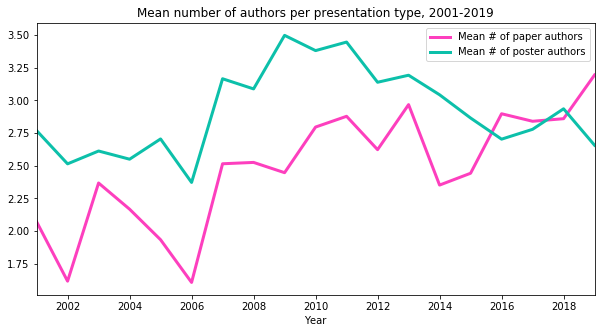

In [30]:
avg_authors_year = mla[["Year","Number of Authors","Type"]].copy()
avg_authors_year = avg_authors_year.groupby(["Year", "Type"], as_index=False).mean()
avg_authors_year = avg_authors_year.pivot(index="Year", columns="Type")

### plot
ax2 = avg_authors_year.plot.line(figsize=(10,5), style=["#fd3fbe", "#0cc0aa"], title="Mean number of authors per presentation type, 2001-2019", linewidth=3)
ax2.legend(["Mean # of paper authors", "Mean # of poster authors"])
fig2 = ax2.get_figure()
fig2.savefig("mean number of authors per presentation type.png", dpi =1000)

## International authors

In [32]:
### this loops through the list and extracts once per country, so it shows how many
### times each country appears at least once in the records
country_counts = []
country_list = ["Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua", 
                "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", 
                "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", 
                "Bhutan", "Bolivia", "Bosnia Herzegovina", "Botswana", "Brazil", "Brunei", 
                "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", 
                "Central African", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", 
                "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", 
                "Dominica", "Dominican Republic", "East Timor", "Ecuador", "Egypt", "El Salvador", 
                "Equatorial Guinea", "Eritrea", "Estonia", "Ethiopia", "Fiji", "Finland", "France", 
                "Gabon", "Gambia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
                "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", 
                "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Ivory Coast", "Japan", 
                "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", 
                "Latvia", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", 
                "Macedonia", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", 
                "Marshall Islands", "Mauritania", "Mauritius", r"(?<!New\s)Mexico", "Micronesia", 
                "Moldova", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Burma", 
                "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", 
                "Nigeria", "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", 
                "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", 
                "Russian Federation", "Russia", "Rwanda", r"(?:St\.?|Saint\s)Kitts", 
                r"(?:St\.?|Saint\s)Lucia", r"(?:St\.?|Saint\s)Vincent", "Samoa", "San Marino", 
                "Sao Tome", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", 
                "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", 
                "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Swaziland", "Sweden", 
                "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Togo", 
                "Tonga", "Trinidad", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", 
                "Ukraine", "United Arab Emirates", "UAE", "United Kingdom", "UK", "Uruguay", 
                "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"]
for country in country_list:
    country_regex = r"(\b"+country+r"\b)"
    occurs = mla["Authors"].str.extract(country_regex,expand=False,flags=re.IGNORECASE).fillna(np.nan)
    occurrence = occurs.value_counts()
    if occurrence.any():
        country_counts.append((country,occurrence.item()))
country_counts.sort(key=lambda tup: tup[1], reverse=True)

### turn into dataframe so it's prettier
country_counts_df = pd.DataFrame(country_counts, columns=["Country", "Count"])
### replace the regex that was needed for Mexico so the name is neat
country_counts_df["Country"].loc[country_counts_df["Country"] == "(?<!New\s)Mexico"] = "Mexico"
display(country_counts_df)

,Country,Count
0,Canada,193
1,United Kingdom,81
2,Taiwan,38
3,China,22
4,Japan,22
5,Australia,19
6,Nigeria,11
7,Netherlands,10
8,India,9
9,Israel,8


# Hospital vs. academic library affiliations

In [33]:
### keywords to look for
hospital_type_keywords = r"(\bhospital\b|\bhealth center\b|\bhealth system\b|\bmedical center\b|\bclinic\b)"
academic_type_keywords = r"(\buniversity\b|\bcollege\b|\bschool\b|\bdepartment\b)"

def find_regex(regex_keywords): ### function to find keywords
    results = mla["Authors"].str.extract(regex_keywords,expand=False,flags=re.IGNORECASE).fillna(np.nan)
    return results

hospital = find_regex(hospital_type_keywords)
print(hospital.value_counts())
print("There are "+str(hospital.loc[hospital != False].count())+" records where the Author field includes a hospital-related keyword")

academic = find_regex(academic_type_keywords)
print(academic.value_counts())
print("There are "+str(academic.loc[academic != False].count())+" records where the Author field includes an academic-related keyword")

Medical Center    584
Hospital          309
Health System      97
Clinic             82
Health Center      19
hospital            1
medical center      1
Name: Authors, dtype: int64
There are 1093 records where the Author field includes a hospital-related keyword
University    3374
School         485
College        354
Department     268
university      24
department       9
school           2
UNIVERSITY       1
Name: Authors, dtype: int64
There are 4517 records where the Author field includes an academic-related keyword


## Plot hospital, academic

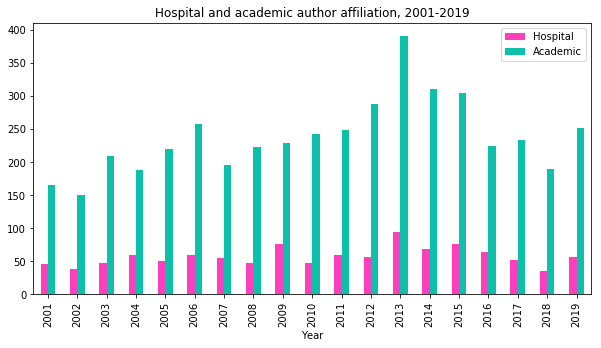

In [35]:
author_inst_type = pd.concat([mla["Year"], hospital, academic], axis=1)
colnames = ["Year", "Hospital", "Academic"]
author_inst_type.columns = colnames

author_inst_type_by_year = author_inst_type.groupby("Year")[["Hospital", "Academic"]]
author_inst_type_by_year = author_inst_type_by_year.count()
#print(author_inst_type_by_year)

ax3 = author_inst_type_by_year.plot.bar(figsize=(10,5), color=["#fd3fbe", "#0cc0aa"], title="Hospital and academic author affiliation, 2001-2019")
fig3 = ax3.get_figure()
ax3.legend(["Hospital", "Academic"])
fig3.savefig("hospital academic authors.png", dpi =1000)